In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

C:\Users\mainf\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
input_dir = 'archive (18)/Data'
categories = ['glioma_tumor','meningioma_tumor','normal','pituitary_tumor']

data = []
labels = []

for category_idx,category in enumerate(categories):
    for file in os.listdir(os.path.join(input_dir,category)):
        img_path = os.path.join(input_dir,category,file)
        img = imread(img_path)
        img = resize(img,(15,15))
        data.append(img.flatten())
        labels.append(category_idx)
        

In [3]:
number_classes = {
    'glioma_tumor': len(os.listdir('archive (18)/Data/glioma_tumor')),
    'meningioma_tumor': len(os.listdir('archive (18)/Data/meningioma_tumor')),
    'normal': len(os.listdir('archive (18)/Data/normal')),
    'pituitary_tumor': len(os.listdir('archive (18)/Data/pituitary_tumor'))
}

In [4]:
number_classes

{'glioma_tumor': 901,
 'meningioma_tumor': 913,
 'normal': 438,
 'pituitary_tumor': 844}

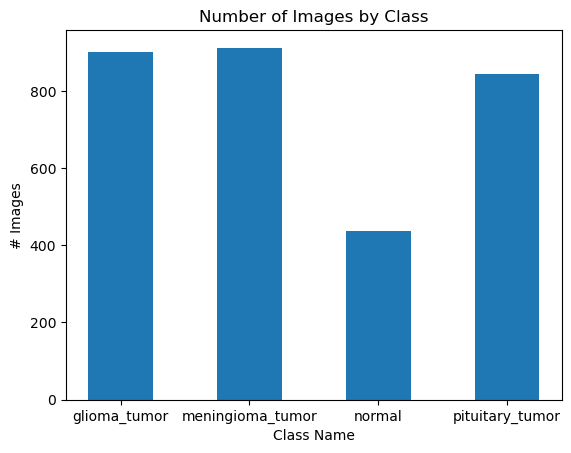

In [5]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

In [6]:
from PIL import Image
import dask.bag as bag
from dask import diagnostics


In [7]:
directories = {
    'glioma_tumor': 'archive (18)/Data/glioma_tumor',
    'meningioma_tumor': 'archive (18)/Data/meningioma_tumor',
    'normal': 'archive (18)/Data/normal',
    'pituitary_tumor': 'archive (18)/Data/pituitary_tumor'
}

def get_dims(file):

    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

In [8]:
get_dims('archive (18)/Data/glioma_tumor/G_1.jpg')

(256, 256)

901
[########################################] | 100% Completed | 2.25 ss
913
[########################################] | 100% Completed | 2.25 ss
438
[########################################] | 100% Completed | 1.74 ss
844
[########################################] | 100% Completed | 1.94 ss


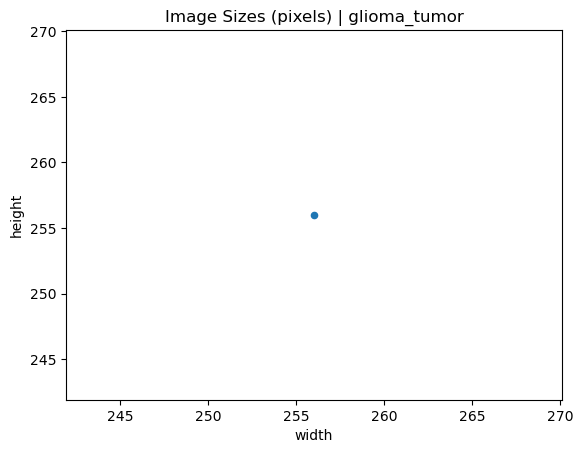

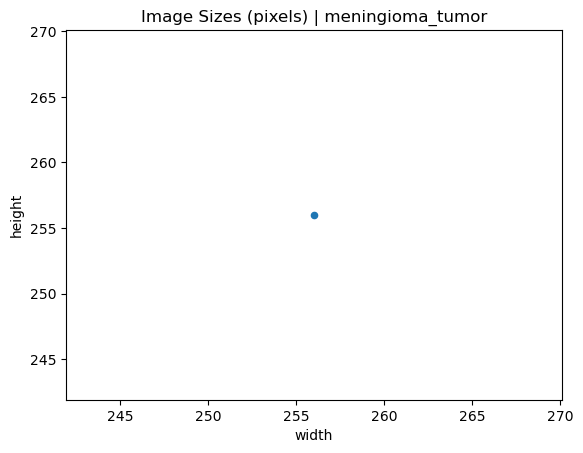

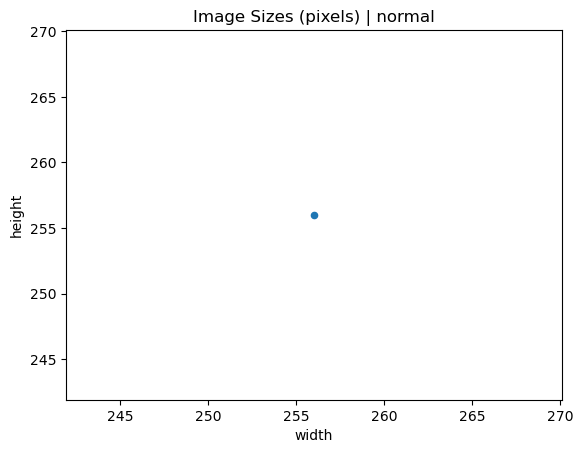

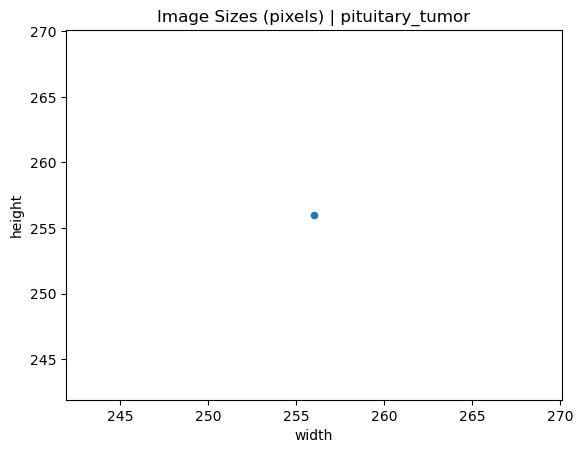

In [9]:
for n,d in directories.items():
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath)]
    print(len(filelist))
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

In [10]:
data = np.asarray(data)
labels = np.asarray(labels)

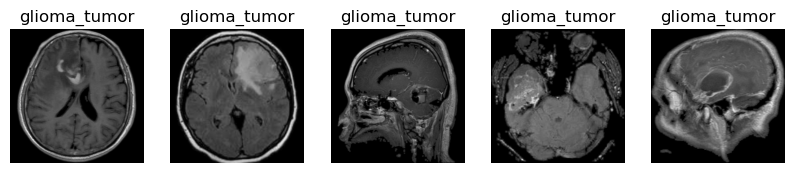

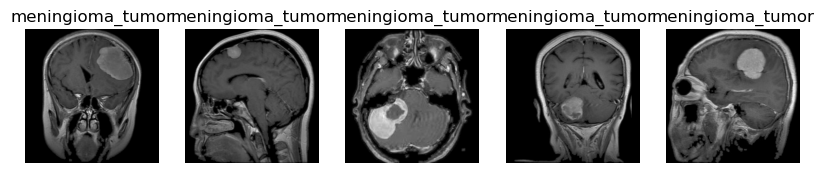

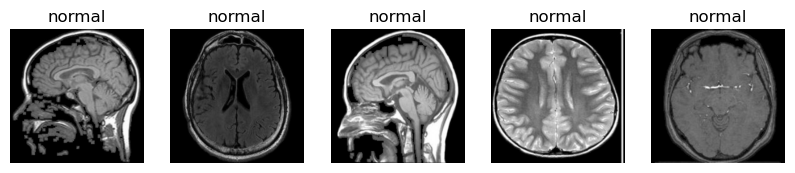

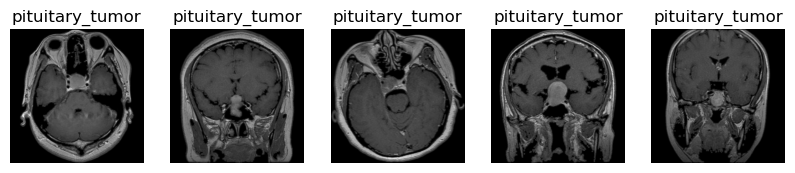

In [11]:
import random
from PIL import Image
for i in directories.values():
    image_files = os.listdir(i) 
    sampled_images = random.sample(image_files, 5)


    plt.figure(figsize=(10, 10)) 
    for j, image_file in enumerate(sampled_images):
        img = Image.open(os.path.join(i, image_file))
        plt.subplot(1, 5, j + 1)
        plt.imshow(img)
        plt.axis('off')
        parts = i.split('/')
        plt.title(parts[-1])
plt.show()


In [12]:
data

array([[1.29676122e-12, 1.29676122e-12, 1.29676122e-12, ...,
        1.74988130e-05, 1.74988130e-05, 1.74988130e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.33767273e-12, 1.33767273e-12, 1.33767273e-12],
       [4.22922865e-14, 4.22922865e-14, 4.22922865e-14, ...,
        4.41609308e-09, 4.41609308e-09, 4.41609308e-09],
       ...,
       [3.82682482e-09, 3.82682482e-09, 3.82682482e-09, ...,
        4.71911205e-05, 4.71911205e-05, 4.71911205e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.41258522e-03, 1.41258522e-03, 1.41258522e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.61911932e-04, 1.61911932e-04, 1.61911932e-04]])

In [13]:
len(data)

3096

In [14]:
len(labels) 

3096

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=.2,stratify=labels,shuffle=True)

In [16]:
classifier = SVC()

parameters = [{'gamma': [0.01,0.001,0.0001],'C':[1,10,100,1000]}]

grid_search = GridSearchCV(classifier, parameters)

grid_search.fit(X_train,y_train)
best_model = grid_search.best_estimator_

In [17]:
y_preds_svc = best_model.predict(X_test)
print(classification_report(y_test,y_preds_svc))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       180
           1       0.84      0.76      0.80       183
           2       0.91      0.88      0.89        88
           3       0.88      0.90      0.89       169

    accuracy                           0.84       620
   macro avg       0.85      0.85      0.85       620
weighted avg       0.85      0.84      0.84       620



In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

#Keras is simplier to use 
#Pytorch is more "Pythonic"
#Tenosr flow is the most complex to learn



In [19]:
print(X_train.shape)


(2476, 675)


In [20]:
from keras.models import Sequential
from keras.layers import Dense

In [21]:
model = Sequential()
model.add(Dense(600, input_shape=(675,), activation='relu'))  
model.add(Dense(300, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
model.fit(X_train,y_train,epochs=100)
y_preds = model.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)

print(classification_report(y_test,class_predictions))

Epoch 1/100


78/78 [==============================] - 1s 4ms/step - loss: 1.2668 - accuracy: 0.3825
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 1.0801 - accuracy: 0.5166
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 0.9752 - accuracy: 0.5763
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.9483 - accuracy: 0.5973
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.8684 - accuracy: 0.6365
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.8241 - accuracy: 0.6640
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.7621 - accuracy: 0.6821
Epoch 8/100
78/78 [==============================] - 0s 4ms/step - loss: 0.7462 - accuracy: 0.6878
Epoch 9/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7365 - accuracy: 0.7019
Epoch 10/100
78/78 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.7387
Epoch 1

78/78 [==============================] - 0s 4ms/step - loss: 0.2148 - accuracy: 0.9277
Epoch 79/100
78/78 [==============================] - 0s 4ms/step - loss: 0.1047 - accuracy: 0.9637
Epoch 80/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0555 - accuracy: 0.9830
Epoch 81/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0223 - accuracy: 0.9956
Epoch 82/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0166 - accuracy: 0.9956
Epoch 83/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0244 - accuracy: 0.9923
Epoch 84/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9669
Epoch 85/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 0.9746
Epoch 86/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0955 - accuracy: 0.9677
Epoch 87/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0889 - accuracy: 0.9637
Epoch 88/100


In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='min')
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 1.1385 - val_accuracy: 0.8694
Epoch 2/100
38/78 [=============>................] - ETA: 0s - loss: 9.4672e-04 - accuracy: 1.0000

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 1.1335 - val_accuracy: 0.8726
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 1.2042 - val_accuracy: 0.8645
Epoch 4/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9988 - val_loss: 1.1630 - val_accuracy: 0.8742
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9988 - val_loss: 1.1996 - val_accuracy: 0.8710
Epoch 6/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 1.2054 - val_accuracy: 0.8694
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.9988 - val_loss: 1.2148 - val_accuracy: 0.8677
Epoch 8/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.9984 - val_loss: 1.2084 - val_accuracy: 0.8710
Epoch 9/100
78/78 [======

Epoch 24: early stopping
20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       180
           1       0.82      0.83      0.82       183
           2       0.87      0.84      0.86        88
           3       0.91      0.95      0.93       169

    accuracy                           0.87       620
   macro avg       0.87      0.86      0.87       620
weighted avg       0.87      0.87      0.87       620



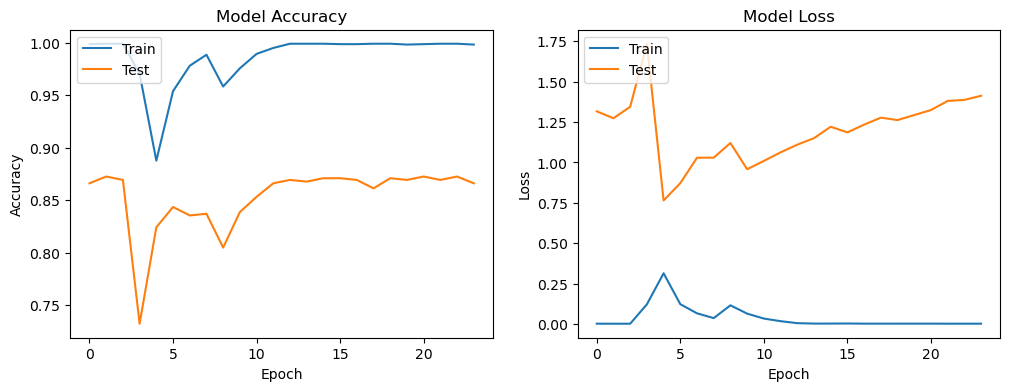

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [34]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout

In [35]:
model2 = Sequential()
model2.add(Dense(600, input_shape=(675,), activation='relu'))
model2.add(Dropout(.05))
model2.add(Dense(300, activation='relu'))
model2.add(Dropout(.05))
model2.add(Dense(150, activation='relu'))
model2.add(Dense(75, activation='relu'))
model2.add(Dropout(.05))
model2.add(Dense(4, activation='softmax'))


optimizers = ['sgd', 'adam', 'rmsprop', 'adagrad', 'adadelta']
loss_functions = ['mean_squared_error', 'binary_crossentropy', 'categorical_crossentropy', 'hinge', 'mean_absolute_error']

model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
checkpoint = ModelCheckpoint('best_model_2.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model2.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.2772 - accuracy: 0.3978 - val_loss: 1.1421 - val_accuracy: 0.5081
Epoch 2/100
32/78 [===========>..................] - ETA: 0s - loss: 1.1456 - accuracy: 0.4746

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 6ms/step - loss: 1.0971 - accuracy: 0.5048 - val_loss: 1.0335 - val_accuracy: 0.5710
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9944 - accuracy: 0.5646 - val_loss: 0.9715 - val_accuracy: 0.5903
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9304 - accuracy: 0.6099 - val_loss: 1.0852 - val_accuracy: 0.5323
Epoch 5/100
78/78 [==============================] - 1s 6ms/step - loss: 0.9001 - accuracy: 0.6248 - val_loss: 0.9572 - val_accuracy: 0.6048
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8277 - accuracy: 0.6620 - val_loss: 0.8881 - val_accuracy: 0.6468
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8473 - accuracy: 0.6478 - val_loss: 0.8907 - val_accuracy: 0.6274
Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7564 - accuracy: 0.6902 - val_loss: 1.0238 - val_accuracy: 0.5903
Epoch 9/100
78/78 [======

Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1962 - accuracy: 0.9293 - val_loss: 0.7261 - val_accuracy: 0.8000
Epoch 61/100
78/78 [==============================] - 0s 5ms/step - loss: 0.2179 - accuracy: 0.9200 - val_loss: 0.7323 - val_accuracy: 0.7935
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2112 - accuracy: 0.9225 - val_loss: 0.7446 - val_accuracy: 0.8161
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1875 - accuracy: 0.9277 - val_loss: 0.7062 - val_accuracy: 0.8355
Epoch 64/100
78/78 [==============================] - 0s 5ms/step - loss: 0.1784 - accuracy: 0.9362 - val_loss: 0.8307 - val_accuracy: 0.7935
Epoch 65/100
78/78 [==============================] - 0s 5ms/step - loss: 0.1888 - accuracy: 0.9301 - val_loss: 0.7420 - val_accuracy: 0.8226
Epoch 66/100
78/78 [==============================] - 0s 5ms/step - loss: 0.1753 - accuracy: 0.9338 - val_loss: 0.7117 - val_accuracy: 0.8129
Epoch 

Epoch 18/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 1.7059 - val_accuracy: 0.8726
Epoch 19/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 1.7728 - val_accuracy: 0.8661
Epoch 20/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 1.8237 - val_accuracy: 0.8613
Epoch 21/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 1.8155 - val_accuracy: 0.8710
Epoch 22/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5870 - accuracy: 0.8445 - val_loss: 0.7512 - val_accuracy: 0.8032
Epoch 23/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1914 - accuracy: 0.9378 - val_loss: 0.8091 - val_accuracy: 0.8177
Epoch 24/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1316 - accuracy: 0.9515 - val_loss: 0.9104 - val_accuracy: 0.8194
Epoch 

In [41]:
model3 = Sequential()
   
model3.add(Dense(600, input_shape=(675,), activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))  
model3.add(Dense(300, activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))
model3.add(Dense(150, activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))
model3.add(Dense(75, activation='relu'))
model3.add(Dense(4, activation='softmax'))

model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [42]:
checkpoint = ModelCheckpoint('best_model_3.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model3.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model3.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 5.6789 - accuracy: 0.3817 - val_loss: 2.3043 - val_accuracy: 0.3581
Epoch 2/100
34/78 [============>.................] - ETA: 0s - loss: 1.9566 - accuracy: 0.4108

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 6ms/step - loss: 1.7552 - accuracy: 0.4140 - val_loss: 1.4889 - val_accuracy: 0.4919
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3794 - accuracy: 0.4851 - val_loss: 1.3996 - val_accuracy: 0.4645
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2979 - accuracy: 0.4867 - val_loss: 1.2553 - val_accuracy: 0.5226
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2398 - accuracy: 0.5279 - val_loss: 1.3182 - val_accuracy: 0.4597
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1807 - accuracy: 0.5634 - val_loss: 1.1567 - val_accuracy: 0.5435
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 1.1985 - accuracy: 0.5424 - val_loss: 1.1901 - val_accuracy: 0.5661
Epoch 8/100
78/78 [==============================] - 0s 5ms/step - loss: 1.1371 - accuracy: 0.5929 - val_loss: 1.1289 - val_accuracy: 0.6177
Epoch 9/100
78/78 [======

Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7663 - accuracy: 0.7843 - val_loss: 1.0062 - val_accuracy: 0.7016
Epoch 61/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7223 - accuracy: 0.8082 - val_loss: 1.0664 - val_accuracy: 0.6871
Epoch 62/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7319 - accuracy: 0.8053 - val_loss: 1.0475 - val_accuracy: 0.6935
Epoch 63/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7844 - accuracy: 0.7884 - val_loss: 1.0973 - val_accuracy: 0.6661
Epoch 64/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7213 - accuracy: 0.8090 - val_loss: 0.9778 - val_accuracy: 0.7306
Epoch 65/100
78/78 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.8187 - val_loss: 0.9513 - val_accuracy: 0.7452
Epoch 66/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7565 - accuracy: 0.7944 - val_loss: 1.0218 - val_accuracy: 0.7323
Epoch 

78/78 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 1.3123 - val_accuracy: 0.8613
Epoch 33/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 1.3708 - val_accuracy: 0.8661
Epoch 34/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 1.4039 - val_accuracy: 0.8661
Epoch 35/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 1.4855 - val_accuracy: 0.8645
Epoch 36/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 1.4896 - val_accuracy: 0.8645
Epoch 37/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 1.4660 - val_accuracy: 0.8597
Epoch 38/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9984 - val_loss: 1.4935 - val_accuracy: 0.8548
Epoch 39/100
78/78 